Final model used is RandomForestClassifier after comparing resluts from :

LogisticRegression, RandomForestClassifier, SVM, GradientBoostingClassifier and XGBOOST with 3 samples of data prepared after feature enineering.


Reading the csv and splitting features and label to x & y

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import precision_score

from sklearn.linear_model import LogisticRegression
from sklearn import svm

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb

%matplotlib inline


dataset = pd.read_csv('Phising_Training_Dataset.csv')

data = dataset.drop("key", axis=1)
x = data.drop("Result", axis=1)
y = data["Result"]
y.replace(-1, 0, inplace=True)

print(data.shape, x.shape, y.shape)
# print(data.describe())


(8955, 31) (8955, 30) (8955,)


Train test split

In [2]:
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.2, random_state=0, stratify= y)

Removing the features with negligible or none correlation with respect to target result

In [3]:
df = pd.DataFrame(data)

def eval_correlation(data, threshold = .009):
    minimal_cr_set = set()
    for (columnName, columnData) in data.iteritems():
        df[columnName] =df[columnName].astype('category').cat.codes
        
    corr_vals = df[df.columns[1:]].corr()['Result']
    for rownum, (indx, val) in enumerate(corr_vals.iteritems()):
        if(abs(val) < threshold):
            minimal_cr_set.add(indx)
    return minimal_cr_set

threshold = 0.01
minimal_cr_set = eval_correlation(df, threshold)
print(f'non correlated features count below threshold of {threshold} : ', len(set(minimal_cr_set)) ) 

# dropping the features with neglible correlation
X_train_uncorr = X_train.drop(labels=minimal_cr_set, axis = 1)
X_test_uncorr = X_test.drop(labels = minimal_cr_set, axis = 1)

X_train_uncorr.shape

non correlated features count below threshold of 0.01 :  3


(7164, 27)

Feature Dimention Reduction attemp using LDA (LinearDiscriminantAnalysis).

LDA is a Classifier too but results(LDA's precision score, i.e. 9.2 before the visual) seems to be not that apealing.

LDA helps reduce the data in one dimention and VISUALISE the variance of data, which seems to have quite some overlap, not much outliers.


(7164, 1) (1791, 1)
(1791, 30)
LDA's precision score :  0.92


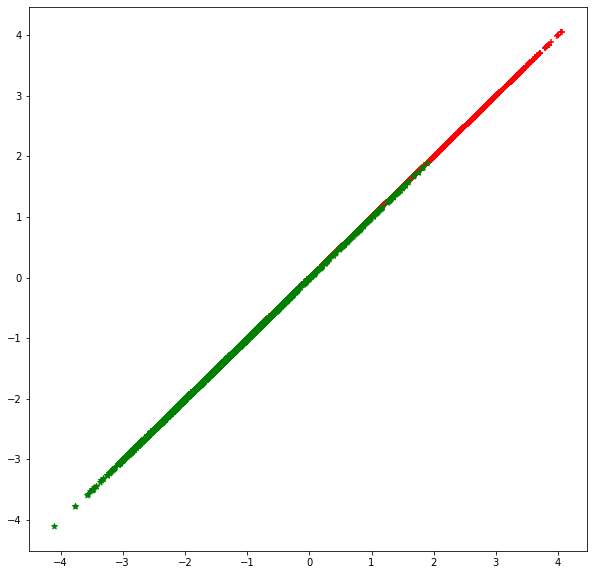

In [4]:

lda = LDA(n_components=1)
X_train_lda = lda.fit_transform(X_train, Y_train)
X_test_lda = lda.transform(X_test)

print(X_train_lda.shape, X_test_lda.shape)
print(X_test.shape)
X_test_pred =lda.predict(X_test)
print("LDA's precision score : ", precision_score(Y_test, X_test_pred))

markers = ['+','*']
colors = ['r','g']

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

for l,m,c in zip(np.unique(Y_train), markers, colors):
    ax.scatter(X_train_lda[:,0][Y_train==l],X_train_lda[:,0][Y_train==l],c=c,marker=m)


Now that there are 3 samples of data:

1. Default(intact)  2. Un-Correlated    3. LDA dim reduced

All 3 samples testing on LogisticRegression, RandomForestClassifier, SVM, GradientBoostingClassifier and XGBOOST follows:


LogisticRegression implementation function

In [5]:
def run_LogisticRegression(x_train_l, x_test_l, y_train_l, y_test_l, type='None'):
    model = LogisticRegression()
    model.fit(x_train_l, y_train_l)
    print(f'LogisticRegression Accuracy on test set with {type} :', model.score(x_test_l, y_test_l))

In [6]:
run_LogisticRegression(X_train_lda, X_test_lda, Y_train, Y_test, type="LDA")
run_LogisticRegression(X_train_uncorr, X_test_uncorr, Y_train, Y_test, type="UNCORR")
run_LogisticRegression(X_train, X_test, Y_train, Y_test, "Default")

LogisticRegression Accuracy on test set with LDA : 0.9302065884980458
LogisticRegression Accuracy on test set with UNCORR : 0.9335566722501396
LogisticRegression Accuracy on test set with Default : 0.9352317141261864


RandomForestClassifier implementation function

In [7]:
final_model_rf = RandomForestClassifier(n_estimators=88, random_state=0, n_jobs=-1)

def run_randomForest(x_train_l, x_test_l, y_train_l, y_test_l, type='None'):
    final_model_rf.fit(x_train_l, y_train_l)
    y_pred = final_model_rf.predict(x_test_l)
    print(f'RandomForestClassifier Accuracy on test set with {type} :', accuracy_score(y_test_l, y_pred))

In [8]:
run_randomForest(X_train_lda, X_test_lda, Y_train, Y_test, type="LDA")
run_randomForest(X_train_uncorr, X_test_uncorr, Y_train, Y_test, type="UNCORR")
run_randomForest(X_train, X_test, Y_train, Y_test, "Default")

RandomForestClassifier Accuracy on test set with LDA : 0.9380234505862647
RandomForestClassifier Accuracy on test set with UNCORR : 0.9709659408151871
RandomForestClassifier Accuracy on test set with Default : 0.9720826353992184


SVM implementation function

In [9]:
def run_SVM(X_train_l, X_test_l, Y_train_l, Y_test_l, type='None'):
    model = svm.SVC(C=9, kernel='poly') #'linear', 'poly', 'rbf', 'sigmoid', 'precomputed'
    model.fit(X_train_l, Y_train_l)
    print(f'SVM Accuracy on test set {type} :', model.score(X_test_l, Y_test_l))

In [10]:
run_SVM(X_train_lda, X_test_lda, Y_train, Y_test, type="LDA")
run_SVM(X_train_uncorr, X_test_uncorr, Y_train, Y_test, type="UNCORR")
run_SVM(X_train, X_test, Y_train, Y_test, "Default")

SVM Accuracy on test set LDA : 0.9050809603573423
SVM Accuracy on test set UNCORR : 0.966499162479062
SVM Accuracy on test set Default : 0.9670575097710776


GradientBoostingClassifier & XGBoost implementation function

In [11]:

def run_gradientBoosting(X_train_l, X_test_l, Y_train_l, Y_test_l, isXGB = True, type='None'):
    prefix = "GradientBoostingClassifier"
    if isXGB:
        prefix = "XGBoost"
    if isXGB:
        train = xgb.DMatrix(X_train_l, label=Y_train_l)
        test = xgb.DMatrix(X_test_l, label=Y_test_l)
        param = {
            'max_depth': 12,
            'eta': 0.33,
            'objective': 'multi:softmax',
            'num_class': 2} 
        epochs = 30 
        model = xgb.train(param, train, epochs)
        y_preds = model.predict(test)
    else:
        model = GradientBoostingClassifier(n_estimators=112)
        model.fit(X_train_l, Y_train_l)
        y_preds = model.predict(X_test_l)
    
    # print(confusion_matrix(Y_test_l, y_preds))
    print(f'{prefix} Accuracy on test set  {type} :', accuracy_score(Y_test_l, y_preds))

In [12]:
run_gradientBoosting(X_train_lda, X_test_lda, Y_train, Y_test, isXGB=False, type="LDA")
run_gradientBoosting(X_train_uncorr, X_test_uncorr, Y_train, Y_test, isXGB=False, type="UNCORR")
run_gradientBoosting(X_train, X_test, Y_train, Y_test, isXGB=False, type="Default")

GradientBoostingClassifier Accuracy on test set  LDA : 0.9285315466219989
GradientBoostingClassifier Accuracy on test set  UNCORR : 0.9519821328866555
GradientBoostingClassifier Accuracy on test set  Default : 0.9536571747627024


In [13]:
run_gradientBoosting(X_train_lda, X_test_lda, Y_train, Y_test, isXGB=True, type="LDA")
run_gradientBoosting(X_train_uncorr, X_test_uncorr, Y_train, Y_test, isXGB=True, type="UNCORR")
run_gradientBoosting(X_train, X_test, Y_train, Y_test, isXGB=True, type="Default")

[22:34:38] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softmax' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBoost Accuracy on test set  LDA : 0.9352317141261864
[22:34:38] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softmax' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBoost Accuracy on test set  UNCORR : 0.9704075935231714
[22:34:39] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softmax' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBoost Accuracy on test set  Default : 0.9676158570630933


RandomForest with intact(all features) and XGBoost with top correlated Features (27) have provided the best predictions!

RandomForestClassifier Accuracy on test set with Default : 0.9720826353992184

XGBoost Accuracy on test set  UNCORR : 0.9704075935231714



Final Predictions on Unseen Data

In [14]:
unseen_data = pd.read_csv('Phising_Testing_Dataset.csv')

keys = unseen_data["key"]
final_test_x = unseen_data.drop("key", axis=1)

#y.replace(-1, 0, inplace=True)

print(unseen_data.shape, final_test_x.shape, keys.shape)

(2100, 31) (2100, 30) (2100,)


Prdictions on final_model_rf for RandomForestClassifier and persisting the results in desired formatted csv named Submission

In [15]:


final_pred = final_model_rf.predict(final_test_x)
print(final_pred.shape)


result = [['key', 'Result']]
for i in range (0, len(keys)):
    fpred_val = final_pred[i]
    if fpred_val == 0:
        fpred_val = -1
    result.append([keys[i], fpred_val])

result_df = pd.DataFrame(result)
result_df.to_csv("Submission.csv", header=False, index=False, sep=',', encoding='utf-8')

(2100,)


That's All!!!


If possible PLEASE do share feedback.